# NASA Defects - 02 - Model

## Setup

If imbalance-learn is not installed, install it using the following command:

```bash
pip install -U imbalanced-learn
```

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import yaml
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
# pd.set_option('display.max_rows', None)

sns.set_style("darkgrid")

from IPython.display import display, Markdown
from pprint import pprint 

DEBUG = True
SEED = 666

In [40]:
DATASET = "jm1.pkl"

import os, sys
COLAB = 'google.colab' in sys.modules
ROOT = "./"

if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
  if not os.path.isdir(ROOT): os.makedirs(ROOT)


def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Import

In [41]:
df = pd.read_pickle(ROOT+"data/"+DATASET)
print(df.shape)
df.head(1)

(7650, 22)


,LOC_BLANK,BRANCH_COUNT,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CYCLOMATIC_COMPLEXITY,DESIGN_COMPLEXITY,ESSENTIAL_COMPLEXITY,LOC_EXECUTABLE,HALSTEAD_CONTENT,HALSTEAD_DIFFICULTY,HALSTEAD_EFFORT,HALSTEAD_ERROR_EST,HALSTEAD_LENGTH,HALSTEAD_LEVEL,HALSTEAD_PROG_TIME,HALSTEAD_VOLUME,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,LOC_TOTAL,label
1,0.0,211.0,0.0,0.0,128.0,104.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1129.0,1


## Set the target and features

In [42]:
target = "label"
features = list(df.columns)
features.remove(target)

x = df[features]
y = df[target]

## Target Distribution

Counter({0: 6023, 1: 1627})


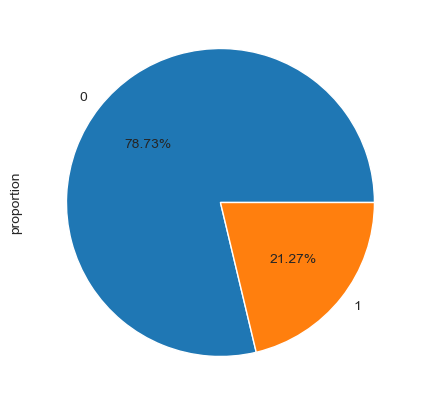

In [43]:
from collections import Counter

y.value_counts(normalize=True).plot(kind="pie", autopct="%.2f%%", figsize=(5,5))

cnter = Counter(y)
pprint(cnter)

## Build Models

### Library import

In [44]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Standard Scaler

In [45]:
ss = StandardScaler()
x = ss.fit_transform(x)

### Setup the models

I've chosen the following models from earlier projects and I researched some other models that could be useful and added the last 2 namely `Multi-Layer Perceptron` and `Gaussian Naive Bayes` to the list of models to be tested.

In [46]:
classifiers = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=10000, random_state=SEED),
    "Decision Tree (depth=0)": DecisionTreeClassifier(random_state=SEED),
    "Decision Tree (depth=5)": DecisionTreeClassifier(max_depth=5, random_state=SEED),
    "Decision Tree (depth=10)": DecisionTreeClassifier(max_depth=10, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Ada Boost": AdaBoostClassifier(algorithm="SAMME", random_state=SEED),
    "Multi-Layer Perceptron": MLPClassifier(random_state=SEED),
    "Gaussian Naive Bayes": GaussianNB()
}

### Train the models 

In [47]:
for name, model in classifiers.items():
    t = time.time()
    model.fit(x, y)
    print(f"{name} trained in {time.time()-t:.2f}s")

Logistic Regression trained in 0.04s
Decision Tree (depth=0) trained in 0.21s
Decision Tree (depth=5) trained in 0.06s
Decision Tree (depth=10) trained in 0.12s
Random Forest trained in 3.05s
Ada Boost trained in 0.67s
Multi-Layer Perceptron trained in 6.86s
Gaussian Naive Bayes trained in 0.00s


### Evaluate the models

The trained models will be evaluated using the following tests

In [48]:
best = None
totals = {}

for name, model in classifiers.items():
    y_pred = model.predict(x)
    
    accuracy_train = accuracy_score(y, y_pred)

    scores = cross_val_score(model, x, y, cv=10, n_jobs=-1)

    confusion = confusion_matrix(y, y_pred)

    classification = classification_report(y, y_pred)

    # Add a markdown cell to the notebook
    display(Markdown(f"## Evaluation Report `{name}`"))
    display(Markdown(f"Accuracy (Train): `{accuracy_train:.2%}`\n\nCross Validation (Test): `{np.mean(scores):.2%} +/- {np.std(scores):.2%}`\n\nConfusion Matrix:\n`{confusion}`\n\nClassification Report:\n```{str(classification)}```"))
    display(Markdown(f"---"))

    if best is None or np.mean(scores) > best[1]:
        best = (name, np.mean(scores))

    totals[name] = np.mean(scores)



## Evaluation Report `Logistic Regression`

Accuracy (Train): `79.40%`

Cross Validation (Test): `79.16% +/- 1.52%`

Confusion Matrix:
`[[5910  113]
 [1463  164]]`

Classification Report:
```              precision    recall  f1-score   support

           0       0.80      0.98      0.88      6023
           1       0.59      0.10      0.17      1627

    accuracy                           0.79      7650
   macro avg       0.70      0.54      0.53      7650
weighted avg       0.76      0.79      0.73      7650
```

---

## Evaluation Report `Decision Tree (depth=0)`

Accuracy (Train): `100.00%`

Cross Validation (Test): `68.29% +/- 2.47%`

Confusion Matrix:
`[[6023    0]
 [   0 1627]]`

Classification Report:
```              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6023
           1       1.00      1.00      1.00      1627

    accuracy                           1.00      7650
   macro avg       1.00      1.00      1.00      7650
weighted avg       1.00      1.00      1.00      7650
```

---

## Evaluation Report `Decision Tree (depth=5)`

Accuracy (Train): `80.35%`

Cross Validation (Test): `78.52% +/- 2.29%`

Confusion Matrix:
`[[5959   64]
 [1439  188]]`

Classification Report:
```              precision    recall  f1-score   support

           0       0.81      0.99      0.89      6023
           1       0.75      0.12      0.20      1627

    accuracy                           0.80      7650
   macro avg       0.78      0.55      0.54      7650
weighted avg       0.79      0.80      0.74      7650
```

---

## Evaluation Report `Decision Tree (depth=10)`

Accuracy (Train): `85.42%`

Cross Validation (Test): `75.65% +/- 1.88%`

Confusion Matrix:
`[[5900  123]
 [ 992  635]]`

Classification Report:
```              precision    recall  f1-score   support

           0       0.86      0.98      0.91      6023
           1       0.84      0.39      0.53      1627

    accuracy                           0.85      7650
   macro avg       0.85      0.68      0.72      7650
weighted avg       0.85      0.85      0.83      7650
```

---

## Evaluation Report `Random Forest`

Accuracy (Train): `100.00%`

Cross Validation (Test): `77.52% +/- 1.29%`

Confusion Matrix:
`[[6023    0]
 [   0 1627]]`

Classification Report:
```              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6023
           1       1.00      1.00      1.00      1627

    accuracy                           1.00      7650
   macro avg       1.00      1.00      1.00      7650
weighted avg       1.00      1.00      1.00      7650
```

---

## Evaluation Report `Ada Boost`

Accuracy (Train): `79.59%`

Cross Validation (Test): `78.39% +/- 0.79%`

Confusion Matrix:
`[[5939   84]
 [1477  150]]`

Classification Report:
```              precision    recall  f1-score   support

           0       0.80      0.99      0.88      6023
           1       0.64      0.09      0.16      1627

    accuracy                           0.80      7650
   macro avg       0.72      0.54      0.52      7650
weighted avg       0.77      0.80      0.73      7650
```

---

## Evaluation Report `Multi-Layer Perceptron`

Accuracy (Train): `81.29%`

Cross Validation (Test): `78.55% +/- 1.54%`

Confusion Matrix:
`[[5945   78]
 [1353  274]]`

Classification Report:
```              precision    recall  f1-score   support

           0       0.81      0.99      0.89      6023
           1       0.78      0.17      0.28      1627

    accuracy                           0.81      7650
   macro avg       0.80      0.58      0.58      7650
weighted avg       0.81      0.81      0.76      7650
```

---

## Evaluation Report `Gaussian Naive Bayes`

Accuracy (Train): `78.00%`

Cross Validation (Test): `77.84% +/- 2.12%`

Confusion Matrix:
`[[5613  410]
 [1273  354]]`

Classification Report:
```              precision    recall  f1-score   support

           0       0.82      0.93      0.87      6023
           1       0.46      0.22      0.30      1627

    accuracy                           0.78      7650
   macro avg       0.64      0.57      0.58      7650
weighted avg       0.74      0.78      0.75      7650
```

---

### Notes on the models:

* Overfitting: Classifiers, `Decision Tree`, `Random Forest`, and `Multi-Layer Perceptron` shows signs of overfitting. The training accuracy is significantly higher than the validation accuracy. MLP only looks like a slight overfitting. 
* Underfitting: There are no signs of underfitting.
* Class performance: All the models have better performance when it comes to predicting `class 0`, which is expected as the dataset is imbalanced and favors `class 0`.
* Based on cross-validation, the best model is `Logistic Regression` with a mean accuracy of `79.16%`, but I dont think it is the best model because of the imbalance in the precision between predicting `class 0` and `class 1`.
* I feel that the best model is between `Multi-Layer Perceptron`, `Decision Tree (Depth=5)`, and `Decision Tree (Depth=10)`.
    * `Multi-Layer Perceptron` has fairly well balanced precision between `class 0` and `class 1`, but it is slightly overfitting. It has a good mean accuracy of `78.55%.`
    * `Decision Tree (Depth=5)` has the same good mean accuracy of `78.52%` and it is not overfitting. It has a slightly better precision for `class 1`, but still well balanced.
    * `Decision Tree (Depth=10)` has the best balance between precision for `class 0` and `class 1`, but it is overfitting hugely. 
* Based on the observations above I will choose `Decision Tree (Depth=5)` as the best model.
